<a href="https://colab.research.google.com/github/R4HUL-ROY/Multimodal_feature_extraction/blob/main/Feature_integration_bert_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Integration

In [1]:
!pip install -q tensorflow_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, Adamax

# Read the dataset and merge Text and Image

In [2]:
img_data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg/')
print(img_data_root)
for item in img_data_root.iterdir():
  print(item)

print()

text_data_root = pathlib.Path('/content/drive/MyDrive/tobaco_OCR/')
print(text_data_root)
for item in text_data_root.iterdir():
  print(item)


/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/ADVE
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Note
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/Letter

/content/drive/MyDrive/tobaco_OCR
/content/drive/MyDrive/tobaco_OCR/Resume
/content/drive/MyDrive/tobaco_OCR/Memo
/content/drive/MyDrive/tobaco_OCR/Letter
/content/drive/MyDrive/tobaco_OCR/Report
/content/drive/MyDrive/tobaco_OCR/Email
/content/drive/MyDrive/tobaco_OCR/ADVE
/content/drive/MyDrive/tobaco_OCR/News
/content/drive/MyDrive/tobaco_OCR/Note
/content/drive/MyDrive/tobaco_OCR/Form
/content/drive/MyDrive/tobaco_OCR/Scientific


In [3]:
def get_corresponding_txtpath(img_path):
    return img_path.replace("Tobacco3482-jpg", "tobaco_OCR")[:-3] + "txt"
    

def get_file_paths_and_labels(img_data_root, text_data_root):
     img_paths = [str(path) for path in img_data_root.glob('*/*.jpg')]
     text_paths = [get_corresponding_txtpath(this_path) for this_path in img_paths]
     img_labels = [p.split("/")[-2] for p in img_paths]
     text_labels = [p.split("/")[-2] for p in text_paths]
     return img_paths, img_labels, text_paths, text_labels

img_paths, img_labels, text_paths, text_labels = get_file_paths_and_labels(img_data_root, text_data_root)
print(len(img_paths))
print(len(img_labels))
print(len(text_paths))
print(len(text_labels))


3482
3482
3482
3482


In [4]:
def get_text_from_path(path):
    with open(path) as f:
        lines = f.readlines()
        lines  = ' '.join(lines)
        f.close()
    return lines

out_text = get_text_from_path('/content/drive/MyDrive/tobaco_OCR/ADVE/0000435350.txt') 
# out_text = preprocess_text(out_text)
print(out_text)


 TE che fitm
 m66400 7127
 KOOLS are the only cigarettes that taste
 good when you have &® cold. They taste even
 better when you don't.
 Job No, K-2978
 ‘Mevapapars—300 iner—Mareh & April, 1956
 (5 9-4 in 4 108 ines) Pinel Proof (7) March 15, 1956



In [5]:
text_contains = []
c= 0 
for i, this_path in enumerate(text_paths):
    text_contains.append(get_text_from_path(this_path))
    print(c, end=" ")
    c +=1 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [6]:
df = pd.DataFrame(list(zip(text_paths, text_contains, img_paths, img_labels)),
               columns =['text_paths','texts', 'img_paths', 'data_label'])

# Merged Dataframe
df.head()

,text_paths,texts,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/ADVE/0000136...,\n \n \n \n A Mpertant as yar\n sesiye teaeter...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
1,/content/drive/MyDrive/tobaco_OCR/ADVE/0000435...,\n TE che fitm\n m66400 7127\n KOOLS are the o...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
2,/content/drive/MyDrive/tobaco_OCR/ADVE/0030049...,SR Onrel ules cee\n Nee dss\n The one tales WT...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
3,/content/drive/MyDrive/tobaco_OCR/ADVE/0000556...,so ARN Rr nr\n BWR Ga ||\n Vending Operators\n...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
4,/content/drive/MyDrive/tobaco_OCR/ADVE/0349627...,\n &\n BR. :\n er non\n be 4\n op Re eo eee ee...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,ADVE


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['data_label']= le.fit_transform(df['data_label'])
df.head()

,text_paths,texts,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/ADVE/0000136...,\n \n \n \n A Mpertant as yar\n sesiye teaeter...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
1,/content/drive/MyDrive/tobaco_OCR/ADVE/0000435...,\n TE che fitm\n m66400 7127\n KOOLS are the o...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
2,/content/drive/MyDrive/tobaco_OCR/ADVE/0030049...,SR Onrel ules cee\n Nee dss\n The one tales WT...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
3,/content/drive/MyDrive/tobaco_OCR/ADVE/0000556...,so ARN Rr nr\n BWR Ga ||\n Vending Operators\n...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
4,/content/drive/MyDrive/tobaco_OCR/ADVE/0349627...,\n &\n BR. :\n er non\n be 4\n op Re eo eee ee...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,0


In [8]:
import re
def preprocess_text(text_string):
    preprocessed_string = re.sub(r'[^\w\s]','',text_string)
    preprocessed_string = preprocessed_string.replace('\n',' ')
    preprocessed_string = preprocessed_string.replace('_',' ')
    preprocessed_string = re.sub(' +', ' ', preprocessed_string)
    return preprocessed_string

In [9]:
# Tokenize, Lemmatize, stopwords removal
import spacy 
import nltk
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

normalize("counting playing the Home", lowercase=True, remove_stopwords=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'count play home'

In [10]:
df['texts'] = [preprocess_text(this_text) for this_text in df['texts']]
df['texts'] = [normalize(this_text, lowercase=True, remove_stopwords=True) for this_text in df['texts']]
df.head()

,text_paths,texts,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/ADVE/0000136...,mpertant yar sesiye teaetered cabiieess baely ...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
1,/content/drive/MyDrive/tobaco_OCR/ADVE/0000435...,te che fitm m66400 7127 kools cigarette taste ...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
2,/content/drive/MyDrive/tobaco_OCR/ADVE/0030049...,sr onrel ules cee nee dss one tale wt lower ta...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
3,/content/drive/MyDrive/tobaco_OCR/ADVE/0000556...,arn rr nr bwr ga vend operator column worth 8 ...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,0
4,/content/drive/MyDrive/tobaco_OCR/ADVE/0349627...,br er non 4 op eo eee ee eee talk smoke decide...,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,0


In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["data_label"].values, random_state=10)
test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df["data_label"].values, random_state=10)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2785
Total validation examples: 349
Total test examples: 348


In [12]:
print(train_df['data_label'].value_counts())
print(test_df['data_label'].value_counts())
print(val_df['data_label'].value_counts())

4    496
1    479
3    453
2    345
7    212
9    209
0    184
6    161
5    150
8     96
Name: data_label, dtype: int64
4    62
1    60
3    57
2    43
9    26
7    26
0    23
6    20
5    19
8    12
Name: data_label, dtype: int64
4    62
1    60
3    57
2    43
7    27
9    26
0    23
6    20
5    19
8    12
Name: data_label, dtype: int64


In [13]:
def dataframe_to_dataset(dataframe):
    columns = ["text_paths","texts", "img_paths", "data_label"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("data_label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [14]:
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, (224, 224))

    return image


def preprocess_text(text):
    preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    bert_preprocess_model = hub.KerasLayer(preprocess_url)
    text = tf.convert_to_tensor([text])
    output = bert_preprocess_model(text)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image = preprocess_image(sample["img_paths"])
    text = preprocess_text(sample["texts"])
    return {"image_inputs": image,  "text_inputs": text}

In [15]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [16]:
def create_text_encoder(text_projection_dims, dropout_rate, text_model_trainable):

    encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"
    bert_model = hub.KerasLayer(encoder_url)

    # Set the trainability of the base encoder.
    bert_model.trainable = text_model_trainable

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    embeddings = bert_model(inputs)["pooled_output"]
    outputs = keras.layers.Dense(units = text_projection_dims)(embeddings)

    return keras.Model(inputs, outputs, name="text_encoder")

In [17]:
def create_vision_encoder(img_projection_dims, dropout_rate, img_base_model_trainable):
    img_shape=(224,224,3)
    seed_value = 42

    base_model= tf.keras.applications.vgg16.VGG16(  include_top=False,
                                                    input_shape=img_shape,
                                                    pooling='avg',
                                                    classes=10,
                                                    weights='imagenet')
    
    base_model.trainable = img_base_model_trainable


    inputs = keras.Input(shape=img_shape)
    x = base_model(inputs, training = img_base_model_trainable)

    outputs =tf.keras.layers.Dense(img_projection_dims, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), 
                         bias_regularizer=regularizers.l1(0.006),activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value))(x)

    model=Model(inputs, outputs)

    # Receive the images as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
    preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image_inputs)

    embeddings = model(preprocessed_image)

    # Create the vision encoder model.
    return keras.Model(image_inputs, embeddings, name="vision_encoder")

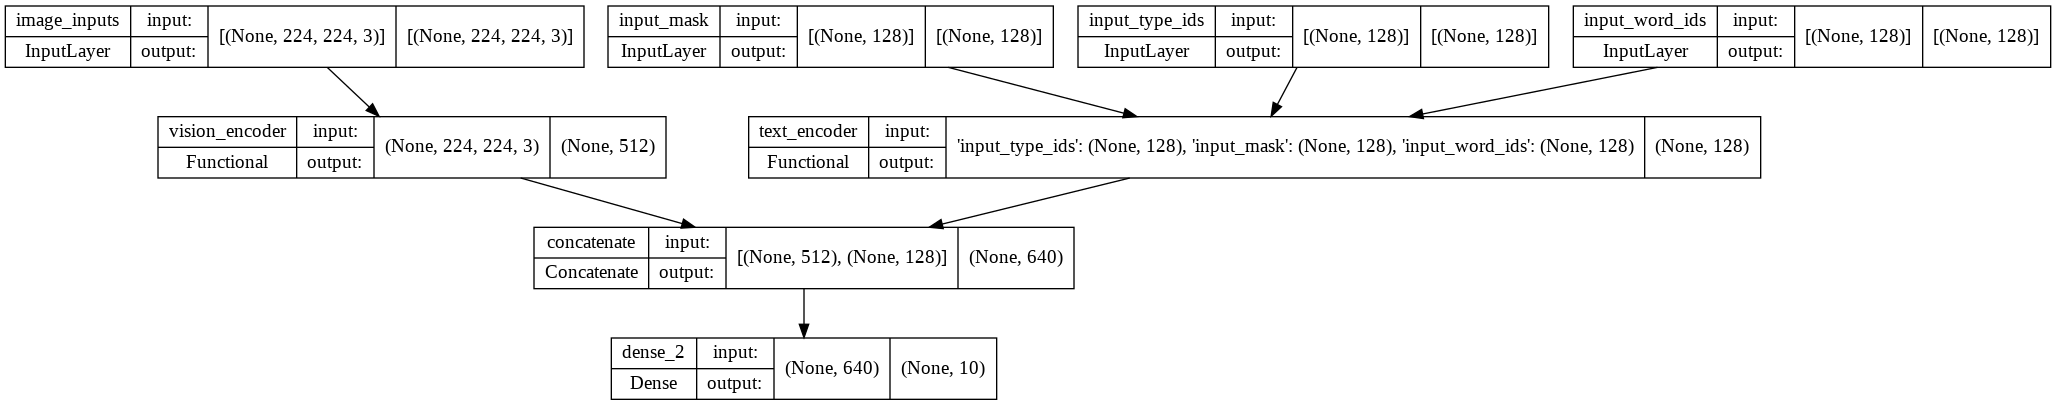

In [18]:
def create_multimodal_model(**kwargs):

    img_projection_dims = kwargs['img_projection_dims']
    text_projection_dims = kwargs['text_projection_dims']
    dropout_rate = kwargs['dropout_rate']
    img_base_model_trainable = kwargs['img_base_model_trainable']
    text_model_trainable = kwargs['text_model_trainable']

    # Receive the images and text as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
    
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(img_projection_dims, dropout_rate, img_base_model_trainable)
    text_encoder = create_text_encoder(text_projection_dims, dropout_rate, text_model_trainable)
    # print(keras.utils.plot_model(text_encoder, show_shapes=True))

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image_inputs)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(10, activation="softmax")(concatenated)
    return keras.Model([image_inputs, text_inputs], outputs)



multimodal_model = create_multimodal_model( img_projection_dims=512,
                                            text_projection_dims=128,
                                            dropout_rate=0.2,
                                            img_base_model_trainable=False,
                                            text_model_trainable=False
                                           )
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [19]:
lr = 0.001
multimodal_model.compile(
    Adamax(learning_rate=lr), loss="sparse_categorical_crossentropy", metrics="accuracy"
)

In [20]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5", verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=20, verbose=2, callbacks=[checkpoint], initial_epoch=0)

Epoch 1/20

Epoch 1: val_loss improved from inf to 5.80654, saving model to /model-001-0.524237-0.610315.h5
88/88 - 102s - loss: 9.5514 - accuracy: 0.5242 - val_loss: 5.8065 - val_accuracy: 0.6103 - 102s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 5.80654 to 4.04975, saving model to /model-002-0.656373-0.638968.h5
88/88 - 19s - loss: 4.7623 - accuracy: 0.6564 - val_loss: 4.0498 - val_accuracy: 0.6390 - 19s/epoch - 221ms/step
Epoch 3/20

Epoch 3: val_loss improved from 4.04975 to 3.29369, saving model to /model-003-0.697307-0.664756.h5
88/88 - 19s - loss: 3.5956 - accuracy: 0.6973 - val_loss: 3.2937 - val_accuracy: 0.6648 - 19s/epoch - 218ms/step
Epoch 4/20

Epoch 4: val_loss improved from 3.29369 to 2.82611, saving model to /model-004-0.728546-0.684814.h5
88/88 - 19s - loss: 2.9837 - accuracy: 0.7285 - val_loss: 2.8261 - val_accuracy: 0.6848 - 19s/epoch - 217ms/step
Epoch 5/20

Epoch 5: val_loss improved from 2.82611 to 2.48963, saving model to /model-005-0.750808-0.684

# Fine-Tuning start

In [21]:
wt = multimodal_model.get_weights()

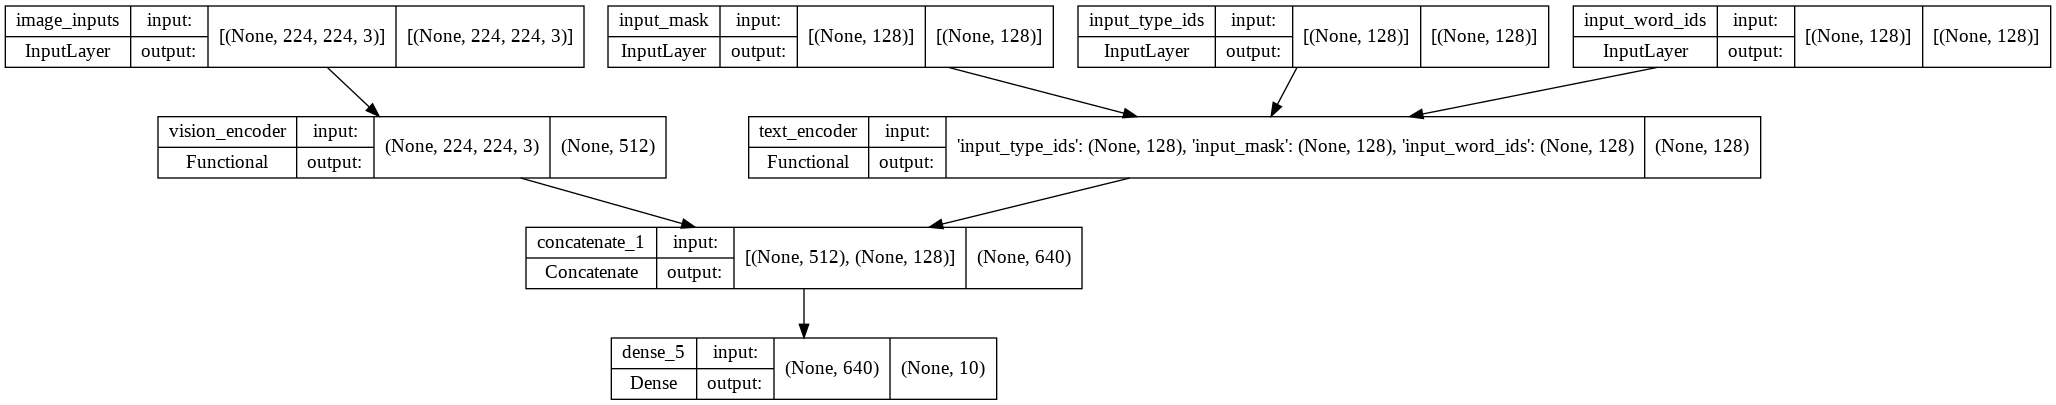

In [22]:
new_multimodal_model = create_multimodal_model( img_projection_dims=512,
                                            text_projection_dims=128,
                                            dropout_rate=0.2,
                                            img_base_model_trainable = True,
                                            text_model_trainable = True
                                           )
keras.utils.plot_model(new_multimodal_model, show_shapes=True)

In [23]:
multimodal_model.evaluate(test_ds, batch_size=32, verbose=2, return_dict=True)

11/11 - 10s - loss: 0.9651 - accuracy: 0.7902 - 10s/epoch - 947ms/step


{'accuracy': 0.790229856967926, 'loss': 0.9650658965110779}

In [24]:
new_multimodal_model.set_weights(wt)

In [25]:
lr = 0.0001
epochs = 20
fine_tune_epochs = 20
total_epochs= epochs + fine_tune_epochs

new_multimodal_model.compile(
    Adamax(learning_rate=lr), loss="sparse_categorical_crossentropy", metrics="accuracy"
)

In [26]:
new_multimodal_model.evaluate(test_ds, batch_size=32, verbose=2, return_dict=True)

11/11 - 3s - loss: 0.9651 - accuracy: 0.7902 - 3s/epoch - 306ms/step


{'accuracy': 0.790229856967926, 'loss': 0.9650658965110779}

In [27]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5", verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

history_fine = new_multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=total_epochs, verbose=2, callbacks=[checkpoint], initial_epoch=epochs)

Epoch 21/40

Epoch 21: val_loss improved from inf to 1.01752, saving model to /model-021-0.665709-0.779370.h5
88/88 - 71s - loss: 1.4503 - accuracy: 0.6657 - val_loss: 1.0175 - val_accuracy: 0.7794 - 71s/epoch - 809ms/step
Epoch 22/40

Epoch 22: val_loss improved from 1.01752 to 0.88075, saving model to /model-022-0.811849-0.810888.h5
88/88 - 48s - loss: 0.8761 - accuracy: 0.8118 - val_loss: 0.8807 - val_accuracy: 0.8109 - 48s/epoch - 549ms/step
Epoch 23/40

Epoch 23: val_loss improved from 0.88075 to 0.84567, saving model to /model-023-0.863196-0.830946.h5
88/88 - 49s - loss: 0.7126 - accuracy: 0.8632 - val_loss: 0.8457 - val_accuracy: 0.8309 - 49s/epoch - 556ms/step
Epoch 24/40

Epoch 24: val_loss improved from 0.84567 to 0.80044, saving model to /model-024-0.890844-0.830946.h5
88/88 - 49s - loss: 0.6276 - accuracy: 0.8908 - val_loss: 0.8004 - val_accuracy: 0.8309 - 49s/epoch - 553ms/step
Epoch 25/40

Epoch 25: val_loss improved from 0.80044 to 0.77522, saving model to /model-025-0.9

In [28]:
new_multimodal_model.evaluate(test_ds, batch_size=32, verbose=2, return_dict=True)

11/11 - 2s - loss: 0.6338 - accuracy: 0.8534 - 2s/epoch - 208ms/step


{'accuracy': 0.8534482717514038, 'loss': 0.633830726146698}

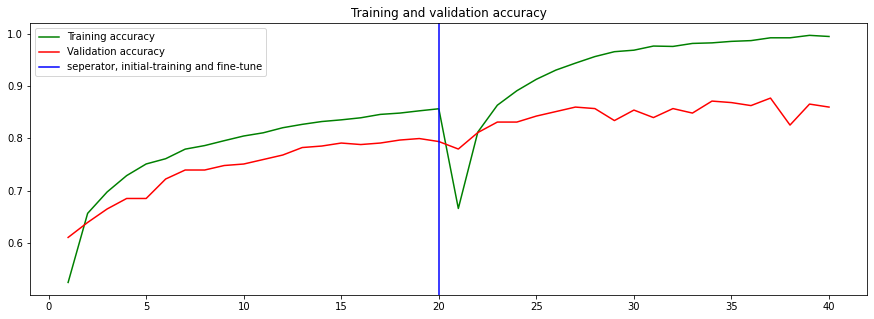

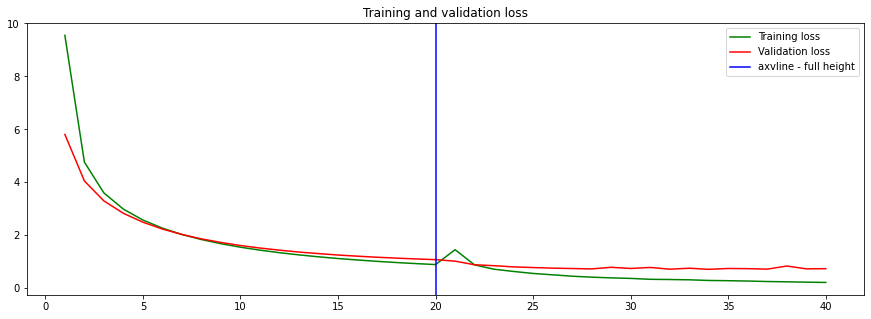

In [29]:
num_epoch = 20
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize = (15, 5))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.axvline(x = num_epoch , color = 'b', label = 'seperator, initial-training and fine-tune')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize = (15, 5))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.axvline(x = num_epoch , color = 'b', label = 'axvline - full height')
plt.title('Training and validation loss')
plt.legend()

plt.show()